In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
import mxnet as mx
import numpy as np

from sklearn import svm
from sklearn import metrics
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import os
import sys
import math
import time
import pickle

proj_dir = os.getcwd()
label_dir = os.path.join(proj_dir, 'emotiondetection/features_labels_lld/labels')
lld_dir = os.path.join(proj_dir, 'emotiondetection/features_labels_lld/lld')

pickle_train_y_list = 'pickle_train_y_list'
pickle_train_x_list = 'pickle_train_x_list'

pickle_test_y_list = 'pickle_test_y_list'
pickle_test_x_list = 'pickle_test_x_list'

In [3]:
mfcc_dir = os.path.join(proj_dir, 'emotiondetection/mfcc_csv')

pickle_train_mfcc_x_list = 'pickle_train_mfcc_x_list'

pickle_test_mfcc_x_list = 'pickle_test_mfcc_x_list'

In [4]:
train_y_list = pickle.load(open(pickle_train_y_list))
train_x_list = pickle.load(open(pickle_train_x_list))

test_y_list = pickle.load(open(pickle_test_y_list))
test_x_list = pickle.load(open(pickle_test_x_list))


train_mfcc_x_list = pickle.load(open(pickle_train_mfcc_x_list))

test_mfcc_x_list = pickle.load(open(pickle_test_mfcc_x_list))

In [5]:
from sklearn.metrics import confusion_matrix
import itertools
def calc_score(test_y_list, predict_y_list):
    print "Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):"
    print 'macro   : ', metrics.precision_recall_fscore_support(test_y_list, predict_y_list, average='macro')
    print 'weighted: ', metrics.precision_recall_fscore_support(test_y_list, predict_y_list, average='weighted')
    print metrics.precision_recall_fscore_support(test_y_list, predict_y_list)
    print confusion_matrix(test_y_list, predict_y_list)

In [6]:
# # z-score normalization
# scaler = preprocessing.StandardScaler().fit(train_x_list)
# train_x_list = scaler.transform(train_x_list)
# test_x_list = scaler.transform(test_x_list)

In [7]:
print train_y_list.shape, train_x_list.shape
print test_y_list.shape, test_x_list.shape

(9959,) (9959, 384)
(8257,) (8257, 384)


In [8]:
print train_x_list[0][:10]
print test_x_list[0][:10]

[  5.66733100e-03   3.11773100e-04   5.35555800e-03   5.30000000e+01
   9.60000000e+01   1.30774500e-03   4.18643100e-06   1.09633100e-03
   1.80239600e-06   1.34818000e-03]
[  1.23016500e-02   9.11361400e-05   1.22105100e-02   5.20000000e+01
   2.40000000e+01   1.31725500e-03   3.23349300e-07   1.29866300e-03
   6.89166500e-06   2.62522000e-03]


# TODO: Just for pre-test, choose only part of all data

In [9]:
# TODO Just for pre-test, choose only part of all data
# If you want to use all data, plea
train_y_list = train_y_list[:500]
test_y_list = test_y_list[:500]
train_mfcc_x_list = train_mfcc_x_list[:500]
test_mfcc_x_list = test_mfcc_x_list[:500]

# cut sentences to frames

In [10]:
# window size
w = 10

# generate training segment data
full_X = []
full_y = []

for i in xrange(len(train_mfcc_x_list)):
    tmp_mfcc_x = train_mfcc_x_list[i]
    tmp_y = train_y_list[i]
    
    frame_count = len(tmp_mfcc_x)
    for j in xrange(frame_count - 2*w):
        tmp_x = np.concatenate(tmp_mfcc_x[j: j+2*w+1])
        full_X.append(tmp_x)
        full_y.append(tmp_y)

full_X = np.array(full_X)
full_y = np.array(full_y)
print 'train:', full_X.shape, full_y.shape

# generate test segment data
full_test_X = []
full_test_y = []

for i in xrange(len(test_mfcc_x_list)):
    tmp_mfcc_x = test_mfcc_x_list[i]
    tmp_y = test_y_list[i]
    
    frame_count = len(tmp_mfcc_x)
    for j in xrange(frame_count - 2*w):
        tmp_x = np.concatenate(tmp_mfcc_x[j: j+2*w+1])
        full_test_X.append(tmp_x)
        full_test_y.append(tmp_y)

full_test_X = np.array(full_test_X)
full_test_y = np.array(full_test_y)
print 'test:', full_test_X.shape, full_test_y.shape

train: (80808, 819) (80808,)
test: (77073, 819) (77073,)


# Train DNN and save models

In [11]:
prefix = 'results/v3/DNN_1024_sig_1024_sig_5'
epochs = 10

In [12]:
# 2-Layer MLP with sigmoid&adam
batch_size = 200
train_iter = mx.io.NDArrayIter(full_X, full_y, batch_size=batch_size)
test_iter = mx.io.NDArrayIter(full_X, full_y, batch_size=batch_size)

data = mx.symbol.Variable('data')
# data = mx.symbol.Dropout(data=data, p=0.2)
# fc0  = mx.symbol.FullyConnected(data = data, name='fc0', num_hidden=1024)
# act0 = mx.symbol.Activation(data = fc0, name='relu0', act_type="sigmoid")
fc1  = mx.symbol.FullyConnected(data = data, name='fc1', num_hidden=1024)
act1 = mx.symbol.Activation(data = fc1, name='relu1', act_type="sigmoid")
fc2  = mx.symbol.FullyConnected(data = fc1, name = 'fc2', num_hidden = 1024)
act2 = mx.symbol.Activation(data = fc2, name='relu2', act_type="sigmoid")
fc3  = mx.symbol.FullyConnected(data = act2, name='fc3', num_hidden=5)
mlp  = mx.symbol.SoftmaxOutput(data = fc3, name = 'softmax')

# mx.viz.plot_network(mlp)

print 'start:', time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime( time.time() ) )

model = mx.model.FeedForward(
    ctx = mx.cpu(),       # Run on CPU
    symbol = mlp,
    num_epoch = epochs,
#     learning_rate = 0.01,
    optimizer = mx.optimizer.Adam(),
    initializer = mx.init.Xavier(factor_type="in", magnitude=2.34))
model.fit(
    X=train_iter,
    eval_data=train_iter,
    epoch_end_callback = mx.callback.do_checkpoint(prefix))  # Logging module to print out progress

print 'start:', time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime( time.time() ) )

# predict_y_score_list = model.predict(test_x_list)
# predict_y_list = np.argmax(predict_y_score_list, axis=1)

# calc_score(test_y_list, predict_y_list)

INFO:root:Start training with [cpu(0)]


start: 2017-01-03 13:17:07


INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=32.747
INFO:root:Saved checkpoint to "results/v3/DNN_1024_sig_1024_sig_5-0001.params"
INFO:root:Epoch[0] Validation-accuracy=0.473420
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=31.729
INFO:root:Saved checkpoint to "results/v3/DNN_1024_sig_1024_sig_5-0002.params"
INFO:root:Epoch[1] Validation-accuracy=0.457259
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Epoch[2] Time cost=26.442
INFO:root:Saved checkpoint to "results/v3/DNN_1024_sig_1024_sig_5-0003.params"
INFO:root:Epoch[2] Validation-accuracy=0.456074
INFO:root:Epoch[3] Resetting Data Iterator
INFO:root:Epoch[3] Time cost=22.846
INFO:root:Saved checkpoint to "results/v3/DNN_1024_sig_1024_sig_5-0004.params"
INFO:root:Epoch[3] Validation-accuracy=0.462778
INFO:root:Epoch[4] Resetting Data Iterator
INFO:root:Epoch[4] Time cost=29.093
INFO:root:Saved checkpoint to "results/v3/DNN_1024_sig_1024_sig_5-0005.params"
INFO:root:Epoch[4]

start: 2017-01-03 13:21:55


# load model and generate segment level feature

In [13]:
model_loaded = mx.model.FeedForward.load(prefix, epochs)

0
84
(84, 819)
(84, 5)


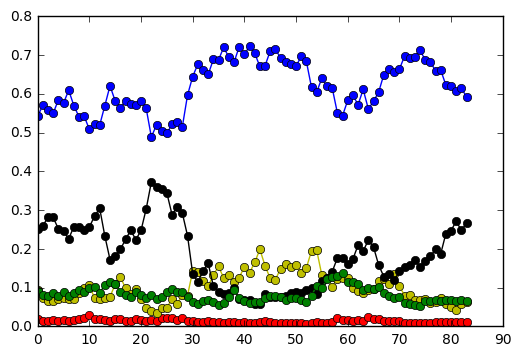

1
100
(100, 819)
(100, 5)


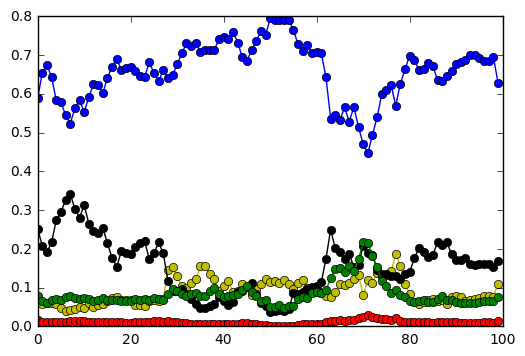

2
217
(217, 819)
(217, 5)


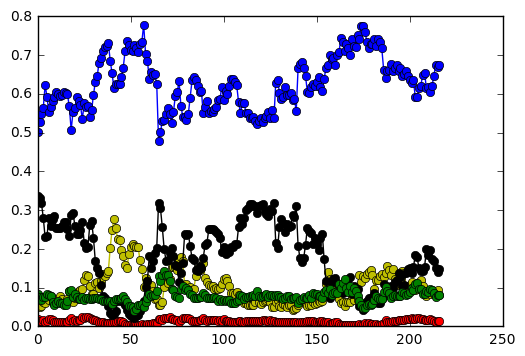

3
107
(107, 819)
(107, 5)


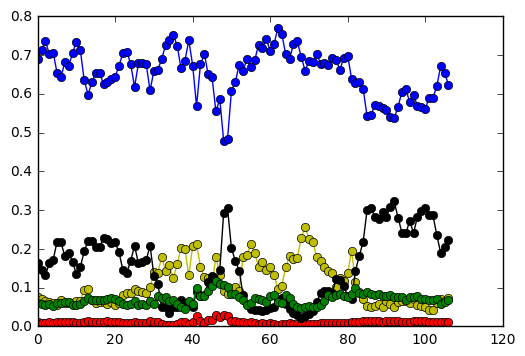

4
81
(81, 819)
(81, 5)


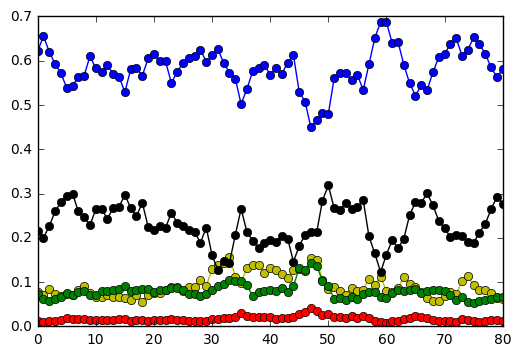

5
116
(116, 819)
(116, 5)


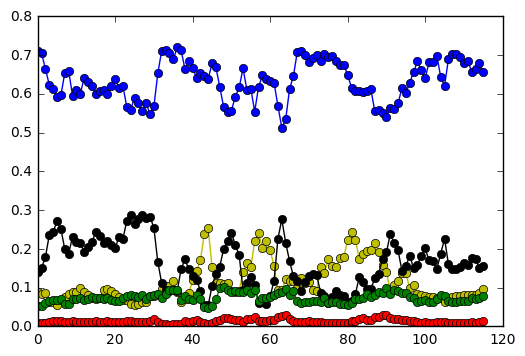

6
129
(129, 819)
(129, 5)


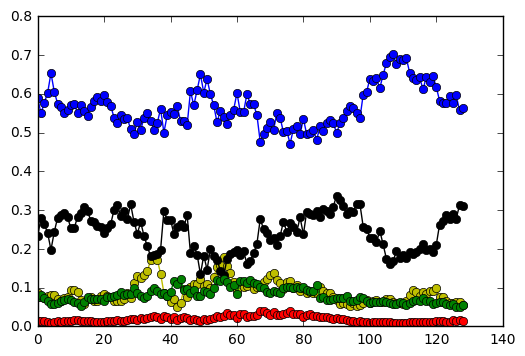

7
85
(85, 819)
(85, 5)


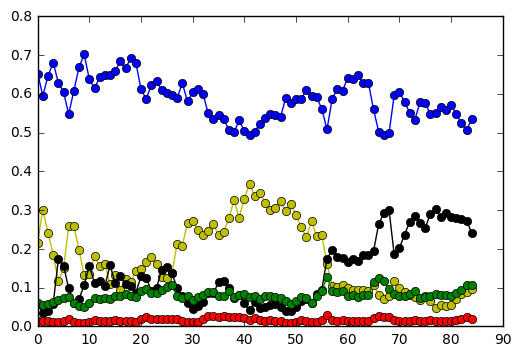

8
89
(89, 819)
(89, 5)


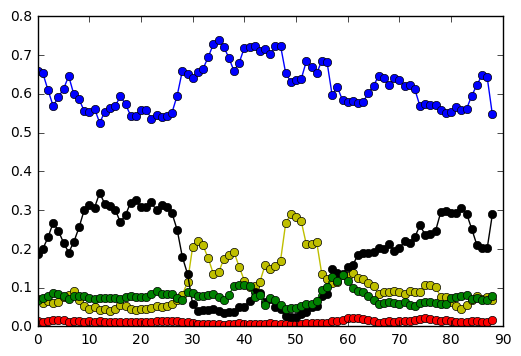

9
219
(219, 819)
(219, 5)


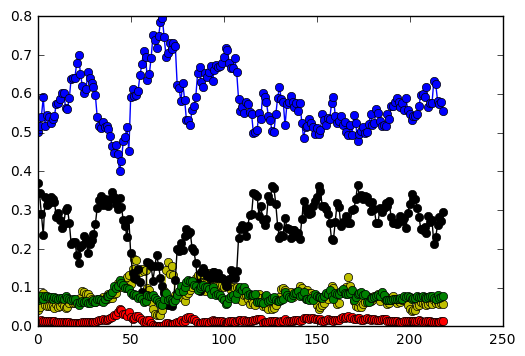

In [14]:
for index in xrange(0, 10):
    print index
    start_i = 0
    for ind in xrange(index):
        tt_mfcc_x = train_mfcc_x_list[ind]
        tt_frame_count = len(tt_mfcc_x) - 2*w
        start_i += tt_frame_count

    tt_mfcc_x = train_mfcc_x_list[index]
    tt_frame_count = len(tt_mfcc_x) - 2*w
    print tt_frame_count

    tt_x_list = full_X[start_i: start_i+tt_frame_count]
    print tt_x_list.shape

    tt_predict_y_score_list = model_loaded.predict(tt_x_list)
    print tt_predict_y_score_list.shape

    color_list = ['r', 'y', 'b', 'k', 'g']
    for i in xrange(5):
        xxx = np.arange(tt_frame_count)
        yyy = tt_predict_y_score_list[:,i]
        plt.plot(xxx, yyy, 'o-', color=color_list[i])
    plt.show()

In [23]:
print train_mfcc_x_list[432].shape
print train_mfcc_x_list[432][0:100].shape

(20, 39)
(20, 39)


In [25]:
seg_thresholds = [0.2, 0.6, 0.6, 0.1, 0.1]

def getSegFeatList(mfcc_x_list):
    x_seg_list = []
    for index in xrange(len(mfcc_x_list)):
        start_i = 0
        for ind in xrange(index):
            tt_mfcc_x = mfcc_x_list[ind]
            tt_frame_count = len(tt_mfcc_x) - 2*w if len(tt_mfcc_x) - 2*w > 0 else 1
            start_i += tt_frame_count

        tt_mfcc_x = mfcc_x_list[index]
        tt_frame_count = len(tt_mfcc_x) - 2*w if len(tt_mfcc_x) - 2*w > 0 else 1
        tt_x_list = full_X[start_i: start_i+tt_frame_count]
        tt_predict_y_score_list = model_loaded.predict(tt_x_list)

        f1 = np.max(tt_predict_y_score_list, axis=0)
        f2 = np.min(tt_predict_y_score_list, axis=0)
        f3 = np.mean(tt_predict_y_score_list, axis=0)
        f4 = np.sum(tt_predict_y_score_list > seg_thresholds, axis=0).astype(float) / len(tt_predict_y_score_list)
        
        x_seg_list.append(np.concatenate([f1, f2, f3, f4]))
    x_seg_list = np.array(x_seg_list)
    return x_seg_list

train_x_seg_list = getSegFeatList(train_mfcc_x_list)
test_x_seg_list = getSegFeatList(test_mfcc_x_list)
print train_x_seg_list.shape, test_x_seg_list.shape

(500, 20) (500, 20)


# construct SVM

In [28]:
# SVM 
print 'start:', time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime( time.time() ) )

clf = svm.SVC().fit(train_x_seg_list, train_y_list)
print clf
predict_y_list = clf.predict(test_x_seg_list)
calc_score(test_y_list, predict_y_list)

print 'end:', time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime( time.time() ) )

start: 2017-01-03 13:40:01
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.1152, 0.20000000000000001, 0.14619289340101521, None)
weighted:  (0.33177599999999996, 0.57599999999999996, 0.42103553299492374, None)
(array([ 0.   ,  0.   ,  0.576,  0.   ,  0.   ]), array([ 0.,  0.,  1.,  0.,  0.]), array([ 0.        ,  0.        ,  0.73096447,  0.        ,  0.        ]), array([ 32, 157, 288,   7,  16]))
[[  0   0  32   0   0]
 [  0   0 157   0   0]
 [  0   0 288   0   0]
 [  0   0   7   0   0]
 [  0   0  16   0   0]]
end: 2017-01-03 13:40:01


In [29]:
pickle.dump(predict_y_list, open(prefix+'-'+str(int(time.time()))+'-'+'pred_y.pkl', 'w'))

In [30]:
# SVM with class_weight='balanced'
print 'start:', time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime( time.time() ) )

clf = svm.SVC(class_weight='balanced').fit(train_x_seg_list, train_y_list)
print clf
predict_y_list = clf.predict(test_x_seg_list)
calc_score(test_y_list, predict_y_list)

print 'end:', time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime( time.time() ) )

start: 2017-01-03 13:40:01
SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Resulting Accuracy (AVG), Recall (AVG), F-Score (AVG):
macro   :  (0.17359349269901286, 0.20473852492164593, 0.13415201955943609, None)
weighted:  (0.38786377151475954, 0.22, 0.2496311328837062, None)
(array([ 0.04      ,  0.29896907,  0.50537634,  0.02362205,  0.        ]), array([ 0.0625    ,  0.36942675,  0.16319444,  0.42857143,  0.        ]), array([ 0.04878049,  0.33048433,  0.24671916,  0.04477612,  0.        ]), array([ 32, 157, 288,   7,  16]))
[[  2  18   4   7   1]
 [ 17  58  36  35  11]
 [ 30 110  47  77  24]
 [  1   1   2   3   0]
 [  0   7   4   5   0]]
end: 2017-01-03 13:40:01


In [31]:
pickle.dump(predict_y_list, open(prefix+'-'+str(int(time.time()))+'-'+'pred_y.pkl', 'w'))